Este cuaderno incluye el código utilizado para el experimento: «Reconstrucción de imágenes usando PDHG» correspondiente a la sección 3.2.4

# Módulos

In [69]:
from cil.framework import BlockDataContainer

from cil.optimisation.functions import L2NormSquared, L1Norm, BlockFunction, MixedL21Norm, IndicatorBox, TotalVariation
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.algorithms import PDHG, SIRT

from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP

from cil.plugins.ccpi_regularisation.functions import FGP_TV

from cil.utilities.display import show2D, show1D, show_geometry
from cil.utilities.jupyter import islicer

from cil.io import ZEISSDataReader

from cil.processors import Binner, TransmissionAbsorptionConverter, Slicer

import matplotlib.pyplot as plt

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow, matshow, show, colorbar, axis
import os
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

In [70]:
def normalizar_imagen(imagen):
    imagen = imagen - np.min(imagen)
    imagen = imagen / np.max(imagen)
    return imagen

# Reconstrucción de imágenes

In [71]:
path = '/home/daniellara/datos/egg1'

In [72]:
reader = ZEISSDataReader()
filename = os.path.join(path, "2014-03-20_946_13","tomo-A","gruppe 1_tomo-A.txrm")
data3D = ZEISSDataReader(file_name=filename).read()

In [73]:
data3D.reorder('astra')

ag3D = data3D.geometry
ig3D = ag3D.get_ImageGeometry()

In [74]:
print(ag3D)

3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -295.02502441,    0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ 0.        , 35.07194901,  0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1024 1024]
	Pixel size: [0.06585424 0.06585424]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 801
	Angles 0-20 in radians:
[-3.1415665, -3.1337643, -3.1259122, -3.118019 , -3.1101823, -3.1023471,
 -3.094488 , -3.0866292, -3.0787868, -3.070933 , -3.063082 , -3.0552533,
 -3.0473654, -3.039515 , -3.03167  , -3.023838 , -3.0159361, -3.0081236,
 -3.0002496, -2.992373 ]
Distances in units: units distance


In [75]:
print(ig3D)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x1024,y1024,z1024
voxel_size : x0.05885739517211914,y0.05885739517211914,z0.05885739517211914
center : x0,y0,z0



Geometría de adquisición

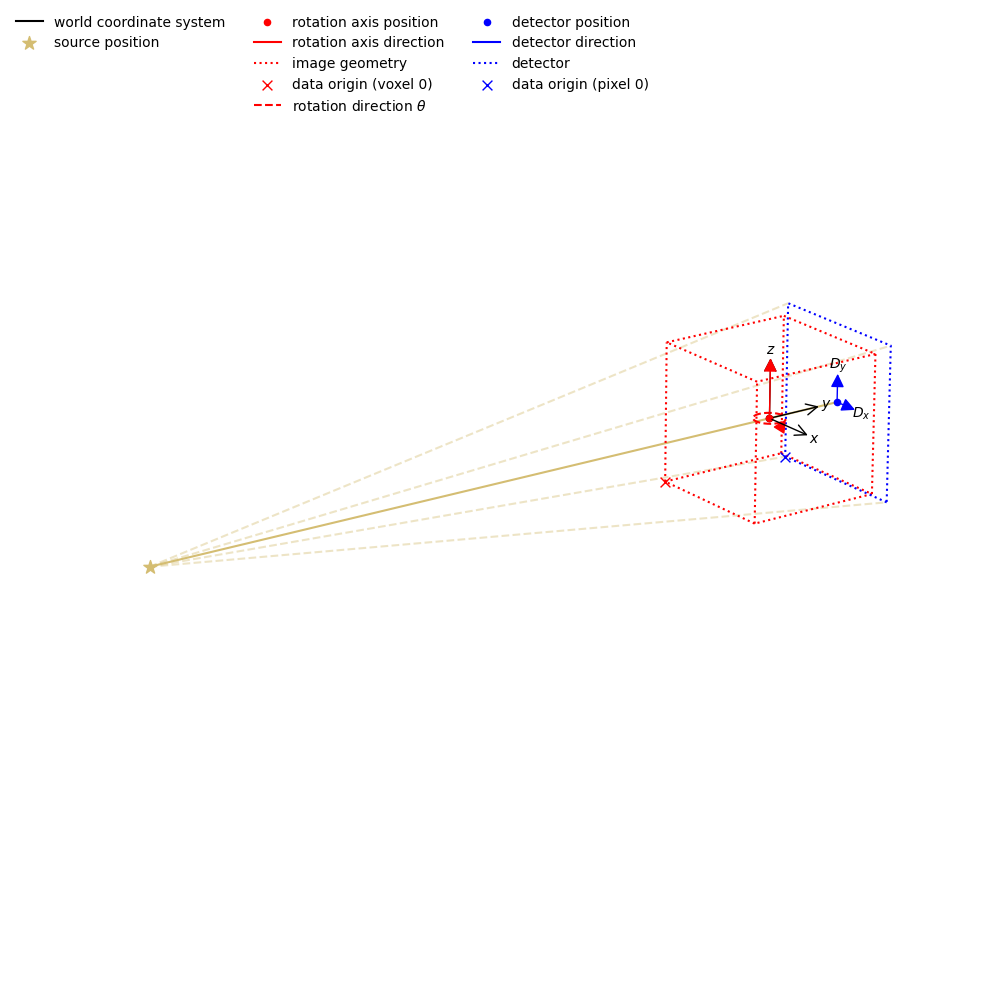

In [76]:
show_geometry(ag3D)

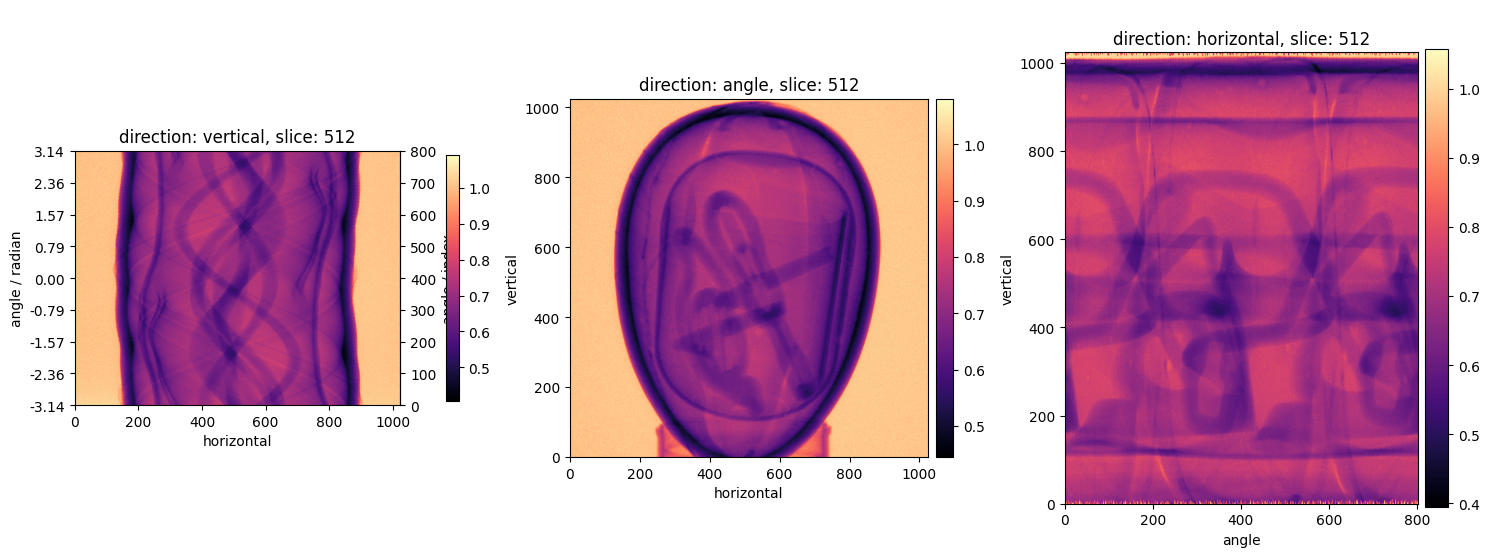

In [77]:
show2D(data3D, slice_list = [('vertical',512), ('angle',512), ('horizontal',512)], cmap="magma", num_cols=3)

In [78]:
islicer(data3D, direction=1, cmap="magma")

Seleccionamos solo una porción de los datos

In [79]:
data2D = data3D.get_slice(vertical='centre')

sliced_data = Slicer(roi={'angle':(0,1600,10)})(data2D)

absorption_data = TransmissionAbsorptionConverter()(sliced_data) 


In [80]:
absorption_data_completo = TransmissionAbsorptionConverter()(data2D) 

In [81]:
ag2D_full = absorption_data_completo.geometry
ag2D_full.set_angles(ag2D_full.angles, initial_angle=0.2, angle_unit='radian')
ig2D_full = ag2D_full.get_ImageGeometry()

fbp_recon_full = FBP(ig2D_full, ag2D_full,  device = 'gpu')(absorption_data_completo)

In [82]:
imagen_base_completa = fbp_recon_full.as_array()

(-0.5, 1023.5, 1023.5, -0.5)

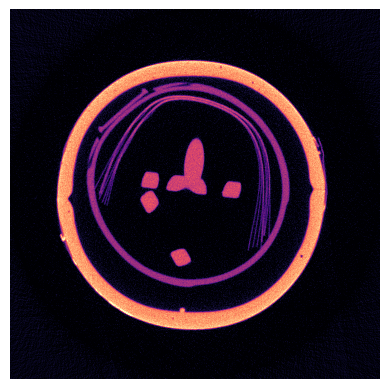

In [83]:
imagen = imshow(imagen_base_completa, cmap='magma',vmin=0, vmax=0.05)
axis('off')

In [84]:
ag2D = absorption_data.geometry
ag2D.set_angles(ag2D.angles, initial_angle=0.2, angle_unit='radian')
ig2D = ag2D.get_ImageGeometry()

In [85]:
print(" Acquisition Geometry 2D: {} with labels {}".format(ag2D.shape, ag2D.dimension_labels))
print(" Image Geometry 2D: {} with labels {}".format(ig2D.shape, ig2D.dimension_labels))

 Acquisition Geometry 2D: (81, 1024) with labels ('angle', 'horizontal')
 Image Geometry 2D: (1024, 1024) with labels ('horizontal_y', 'horizontal_x')


In [86]:
A = ProjectionOperator(ig2D, ag2D, device = "gpu")

Reconstrucción incompleta

(-0.5, 1023.5, 1023.5, -0.5)

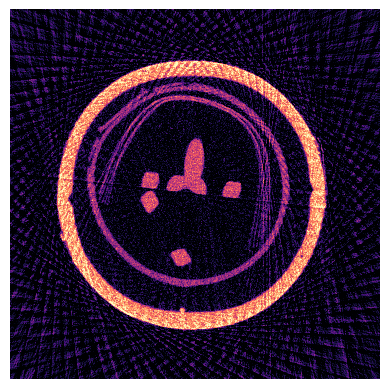

In [87]:
fbp_recon = FBP(ig2D, ag2D,  device = 'gpu')(absorption_data)
imagen_fbp_incompleta = fbp_recon.as_array()

imshow(imagen_fbp_incompleta, cmap='magma',vmin=0, vmax=0.05)
axis('off')

### Regularización L_1

In [88]:
K = A
F = 0.5 * L2NormSquared(b=absorption_data)
alpha = 0.01
G = alpha * L1Norm()

In [89]:
pdhg_l1 = PDHG(f = F, g = G, operator = K, 
            max_iteration = 500,
            update_objective_interval = 100)
pdhg_l1.run(verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          5.67232e+03
      100        500         0.022          5.87370e+01
      200        500         0.022          5.86127e+01
      300        500         0.022          5.85766e+01
      400        500         0.022          5.85572e+01
      500        500         0.022          5.85446e+01
-------------------------------------------------------
      500        500         0.022          5.85446e+01
Stop criterion has been reached.



(-0.5, 1023.5, 1023.5, -0.5)

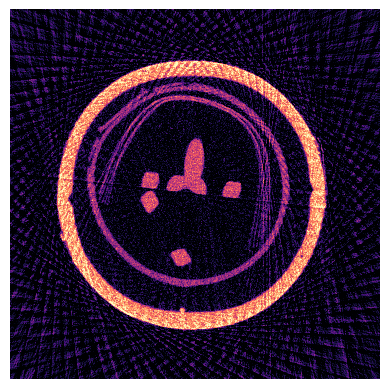

In [90]:
datos_l1 = pdhg_l1.solution

datos_img = fbp_recon.as_array().copy()

imagen = imshow(datos_img, cmap='magma',vmin=0, vmax=0.05)
axis('off')

In [91]:
structural_similarity(normalizar_imagen(imagen_base_completa), normalizar_imagen(imagen_fbp_incompleta), data_range=1)

0.3240914361042054

In [92]:
peak_signal_noise_ratio(normalizar_imagen(imagen_base_completa), normalizar_imagen(imagen_fbp_incompleta), data_range=1)

15.130309264448874

(-0.5, 1023.5, 1023.5, -0.5)

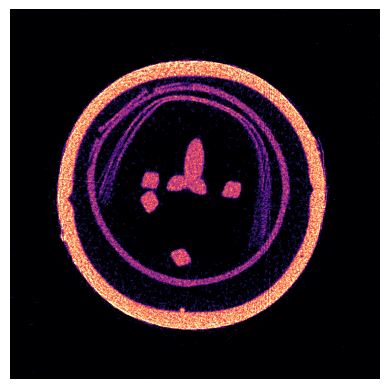

In [93]:
imagen = imshow(datos_l1.as_array(), cmap='magma',vmin=0, vmax=0.05)
axis('off')

In [94]:
structural_similarity(normalizar_imagen(imagen_base_completa), normalizar_imagen(datos_l1.as_array()), data_range=1)


0.2977523777221203

In [95]:
peak_signal_noise_ratio(normalizar_imagen(imagen_base_completa), normalizar_imagen(datos_l1.as_array()), data_range=1)

14.834774977622933

# Regularización total

In [96]:
alpha_tv = 0.0003
f1 = alpha_tv * MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=absorption_data)
F = BlockFunction(f1, f2)

Grad = GradientOperator(ig2D)
K = BlockOperator(Grad, A)

G = IndicatorBox(lower=0)

pdhg_tv_explicit = PDHG(f = F, g = G, operator = K,
            max_iteration = 1000,
            update_objective_interval = 200)
pdhg_tv_explicit.run(verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          5.67232e+03
      200       1000         0.041          1.12971e+01
      400       1000         0.041          1.09093e+01
      600       1000         0.040          1.09034e+01
      800       1000         0.040          1.09030e+01
     1000       1000         0.040          1.09029e+01
-------------------------------------------------------
     1000       1000         0.040          1.09029e+01
Stop criterion has been reached.



(-0.5, 1023.5, 1023.5, -0.5)

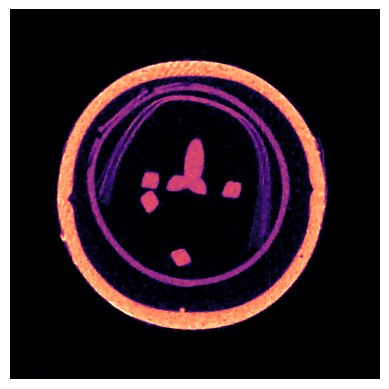

In [97]:
imagen = imshow(pdhg_tv_explicit.solution.as_array(), cmap='magma',vmin=0, vmax=0.05)
axis('off')

In [98]:
peak_signal_noise_ratio(normalizar_imagen(imagen_base_completa), normalizar_imagen(pdhg_tv_explicit.solution.as_array()), data_range=1)

13.402298330689021

In [99]:
structural_similarity(normalizar_imagen(imagen_base_completa), normalizar_imagen(pdhg_tv_explicit.solution.as_array()), data_range=1)


0.09327278189323465

## Regularización del Tikhonov


In [100]:
alpha_tikhonov = 0.05
f1 = alpha_tikhonov * L2NormSquared()
F = BlockFunction(f1, f2)

pdhg_tikhonov_explicit = PDHG(f = F, g = G, operator = K,
            max_iteration = 1000,
            update_objective_interval = 200)
pdhg_tikhonov_explicit.run(verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          5.67232e+03
      200       1000         0.033          2.25687e+01
      400       1000         0.032          2.23748e+01
      600       1000         0.032          2.23746e+01
      800       1000         0.032          2.23746e+01
     1000       1000         0.032          2.23746e+01
-------------------------------------------------------
     1000       1000         0.032          2.23746e+01
Stop criterion has been reached.



(-0.5, 1023.5, 1023.5, -0.5)

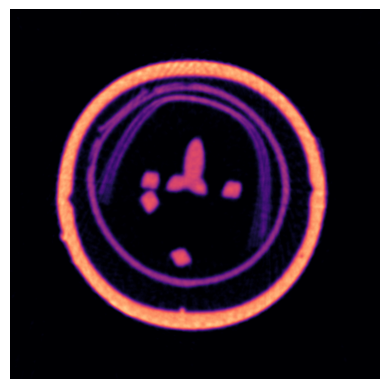

In [101]:
imagen = imshow(pdhg_tikhonov_explicit.solution.as_array(), cmap='magma',vmin=0, vmax=0.05)
axis('off')

In [102]:
structural_similarity(normalizar_imagen(imagen_base_completa), normalizar_imagen(pdhg_tikhonov_explicit.solution.as_array()), data_range=1)


0.10396476406063816

In [103]:
peak_signal_noise_ratio(normalizar_imagen(imagen_base_completa), normalizar_imagen(pdhg_tikhonov_explicit.solution.as_array()), data_range=1)

13.568721887233771